# 维纳滤波
<img src=../assest/winner.jpg>

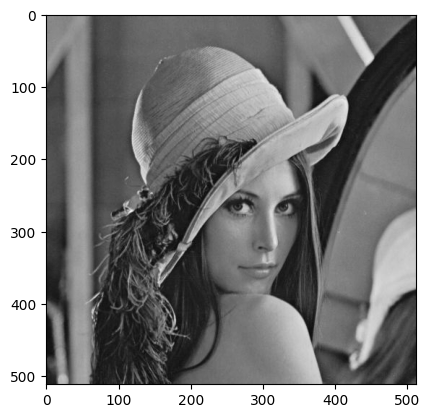

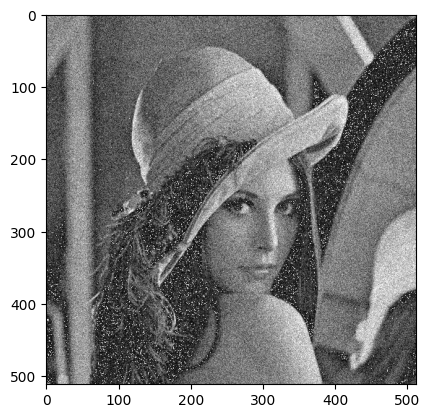

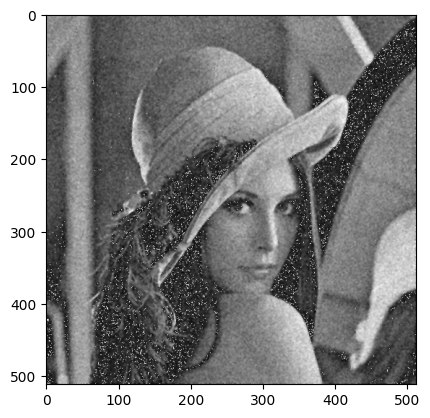

In [1]:
from scipy.signal import wiener
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gasuss_noise(image, mean=0, var=0.01):
    '''
        添加高斯噪声
        mean : 均值
        var : 方差
    '''
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    #cv.imshow("gasuss", out)
    return out

if __name__ == '__main__':
    lena = cv2.imread(r'..\assest\lean.jpg')
    if lena.shape[-1] == 3:
        lenaGray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
    else:
        lenaGray = lena.copy()

    plt.figure('原图')
    plt.imshow(lenaGray, cmap='gray')

    # 添加高斯噪声
    lenaNoise = gasuss_noise(lenaGray)

    plt.figure('添加高斯噪声后的图像')
    plt.imshow(lenaNoise, cmap='gray')

    # 维纳滤波
    lenaNoise = lenaNoise.astype('float64')
    lenaWiener = wiener(lenaNoise, [3, 3])
    lenaWiener = np.uint8(lenaWiener / lenaWiener.max() * 255)

    plt.figure('经过维纳滤波后的图像')
    plt.imshow(lenaWiener, cmap='gray')
    plt.show()
